In [1]:
import types
import pandas as pd
from botocore.client import Config # For Importing Data from IBM Storage
import ibm_boto3
import requests #To handle HTTPS requests
from bs4 import BeautifulSoup #To extract data out of HTML/XML
from pandas.io.json import json_normalize#Transform json file to pandas Data Frame
from sklearn.cluster import KMeans #import k-means from clustering
import matplotlib.cm as cm#Matplotlib and its plotting modules
import matplotlib.colors as colors
import json # To read json files
from math import cos, asin, sqrt, radians, sin # To calculate the Haversine Formula
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # Kmeans Cluster Algorihm
from sklearn.metrics import silhouette_score # To determine best K for the KMeans
import numpy as np

In [2]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # Convert an address to Latitude an Longitude

In [3]:
#!conda install -c conda-forge folium
import folium #Map Rendering Library
from folium import plugins

In [4]:
def __iter__(self): return 0

Obtaining New York crime data from NYPD Open Data

In [5]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_68e7d9056f2c4416a8662970f50e8c18 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='_anf1yfVoU1u4TWBMNgzdOSYc_4LpX9oezr0-E8LbhmH',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
body = client_68e7d9056f2c4416a8662970f50e8c18.get_object(Bucket='applieddatasciencecapstoneproject-donotdelete-pr-zbsuvzjjiph9pp',Key='NYPD_Complaint_Data_Historic (1).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [6]:
#NEW YORK CRIME DATA
nycrime_data= pd.read_csv(body)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#Checking columns and Data Pre Processing
nycrime_data.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

Data PreProcessing-Removing unnecessary columns

In [8]:
nycrime_data=nycrime_data.drop(columns=['CMPLNT_NUM','CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD','PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD','LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME','VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'])

In [9]:
#Selecting Data for just last 1 year
nycrime_data.head()
nycrime_data.rename(columns={"CMPLNT_FR_DT":"DATE","OFNS_DESC":"OFFENSE","BORO_NM":"BOROUGH"},inplace=True)
nycrime_data['DATE']=pd.to_datetime(nycrime_data['DATE'])
start_date='2020-01-01'
end_date='2021-01-01'
mask=(nycrime_data['DATE']>start_date)&(nycrime_data['DATE']<=end_date)
nycrime_data=nycrime_data.loc[start_date:end_date]
nycrime_data.shape

(1000, 5)

In [10]:
#Drop any NaN values
nycrime_data.dropna(inplace=True)
nycrime_data.shape
nycrime_data.head()

DATE                         OFFENSE    BOROUGH   Latitude  \
2020000 2019-04-12  CRIMINAL MISCHIEF & RELATED OF  MANHATTAN  40.764007   
2020001 2019-04-12                 DANGEROUS DRUGS     QUEENS  40.602195   
2020002 2019-04-12                   HARRASSMENT 2     QUEENS  40.751482   
2020003 2019-04-12                   PETIT LARCENY  MANHATTAN  40.718027   
2020004 2019-04-12                   PETIT LARCENY   BROOKLYN  40.630754   

         Longitude  
2020000 -73.996005  
2020001 -73.749104  
2020002 -73.822033  
2020003 -73.999958  
2020004 -73.977167

Mapping All the Offenses in New York

In [11]:
NY_map=folium.Map(location=[40.71, -74.0],zoom_start=10)
incidents=folium.plugins.MarkerCluster().add_to(NY_map)
for lat,lng,label in zip(nycrime_data.Latitude,nycrime_data.Longitude,nycrime_data.OFFENSE):
    folium.features.CircleMarker(
    [lat,lng],radius=5,color='red',fill=True,fill_color='blue',fill_opacity=0.6,popup=label).add_to(incidents)
NY_map

In [12]:
#Finding Borough with Largest Number of Crimes Reported
borough_data=nycrime_data.groupby('BOROUGH')['OFFENSE'].count()
borough_data=borough_data.to_frame()

Brooklyn Has the Highest Number of Crimes Commited and Staten Island has the least number of crimes commited

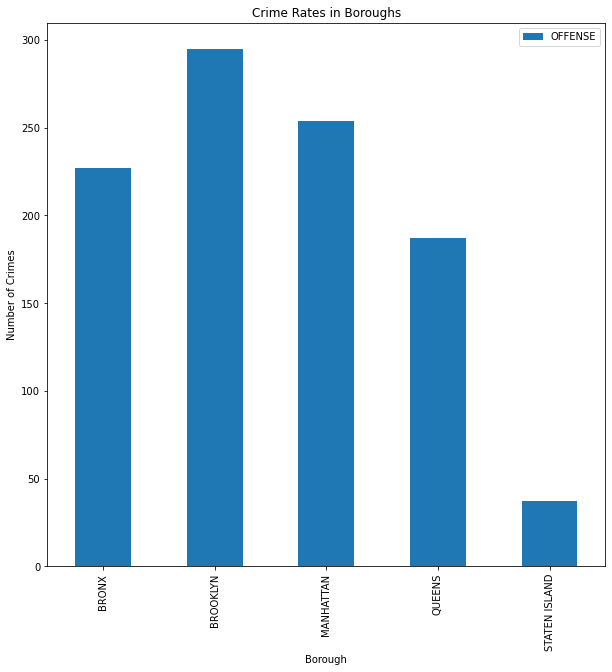

In [13]:
borough_data.plot(kind='bar',figsize=(10,10))
plt.xlabel('Borough')
plt.ylabel('Number of Crimes')
plt.title('Crime Rates in Boroughs')
plt.show()

Finding the Neighbourhood with the largest number of crimes

In [14]:
#Checking in which neighborhood the crimes where commited based on the latitude and longitude
#Getting Neighbourhood Latitude and Longitude
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [15]:
with open ('newyork_data.json') as json_data:
    newyork_data =json.load(json_data)
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [16]:
#As the information we desire is under the features tab, getting just the features from the json file
nyneigh_data=newyork_data['features']
nyneigh_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [17]:
#Creating an empty Data Frame
column_name=['Borough','Neighbourhood','Latitude','Longitude']
neigh_data=pd.DataFrame(columns=column_name)
neigh_data

Empty DataFrame
Columns: [Borough, Neighbourhood, Latitude, Longitude]
Index: []

In [18]:
#Populating the details from the json file to the DataFrame
for data in nyneigh_data:
    borough=data['properties']['borough']
    neigh=data['properties']['name']
    latlong=data['geometry']['coordinates']
    lat=latlong[1]
    lng=latlong[0]
    neigh_data=neigh_data.append({'Borough':borough,'Neighbourhood':neigh,'Latitude':lat,'Longitude':lng},ignore_index=True)
    

In [19]:
neigh_data.head()

Borough Neighbourhood   Latitude  Longitude
0   Bronx     Wakefield  40.894705 -73.847201
1   Bronx    Co-op City  40.874294 -73.829939
2   Bronx   Eastchester  40.887556 -73.827806
3   Bronx     Fieldston  40.895437 -73.905643
4   Bronx     Riverdale  40.890834 -73.912585

Using the Haversine formula to find the distance between two points given the Latitudes and Longitudes

In [20]:
#Function to calculate distance between 2 points
def dist(lat1, long1, lat2, long2):
    """Calculate the great circle distance between two points 
    on the earth"""
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [21]:
#Function to find the nearest neighborhood in which the crime occured
def find_neigh(lat, long):
    distances = neigh_data.apply(
        lambda row: dist(lat, long, row['Latitude'], row['Longitude']), 
        axis=1)
    return neigh_data.loc[distances.idxmin(), 'Neighbourhood']

Finding the neighborhood in which the crimes occured

In [22]:
#Creating a new column in the Nycrime Data called the Neighborhood and Finding the nearest neighbourhood in which the crime occured
nycrime_data['Neighbourhood'] = nycrime_data.apply(
    lambda row: find_neigh(row['Latitude'], row['Longitude']), 
    axis=1)
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
nycrime_data.head()

DATE                         OFFENSE    BOROUGH   Latitude  \
2020000 2019-04-12  CRIMINAL MISCHIEF & RELATED OF  MANHATTAN  40.764007   
2020001 2019-04-12                 DANGEROUS DRUGS     QUEENS  40.602195   
2020002 2019-04-12                   HARRASSMENT 2     QUEENS  40.751482   
2020003 2019-04-12                   PETIT LARCENY  MANHATTAN  40.718027   
2020004 2019-04-12                   PETIT LARCENY   BROOKLYN  40.630754   

         Longitude    Neighbourhood  
2020000 -73.996005          Clinton  
2020001 -73.749104     Far Rockaway  
2020002 -73.822033  Queensboro Hill  
2020003 -73.999958     Little Italy  
2020004 -73.977167     Borough Park

Find the Neighborhood in which there are largest number of crimes

In [23]:
#Finding the neighbrohood with least and largest number of crimes
neighcrime_data=nycrime_data.groupby('Neighbourhood')['OFFENSE'].count()
neighcrime_data=neighcrime_data.to_frame()
print(neighcrime_data.loc[neighcrime_data['OFFENSE'].idxmax()])
print(neighcrime_data.loc[neighcrime_data['OFFENSE'].idxmin()])

OFFENSE    23
Name: East Harlem, dtype: int64
OFFENSE    1
Name: Brooklyn Heights, dtype: int64


In [24]:
neighcrime_data=neighcrime_data.sort_values(by=['OFFENSE'])
neighcrime_data[neighcrime_data['OFFENSE']==1].count()

OFFENSE    38
dtype: int64

East Harlem has the highest number of Crimes reported(23) and 38 other neighbourhoods has the least number of crimes reported(1)

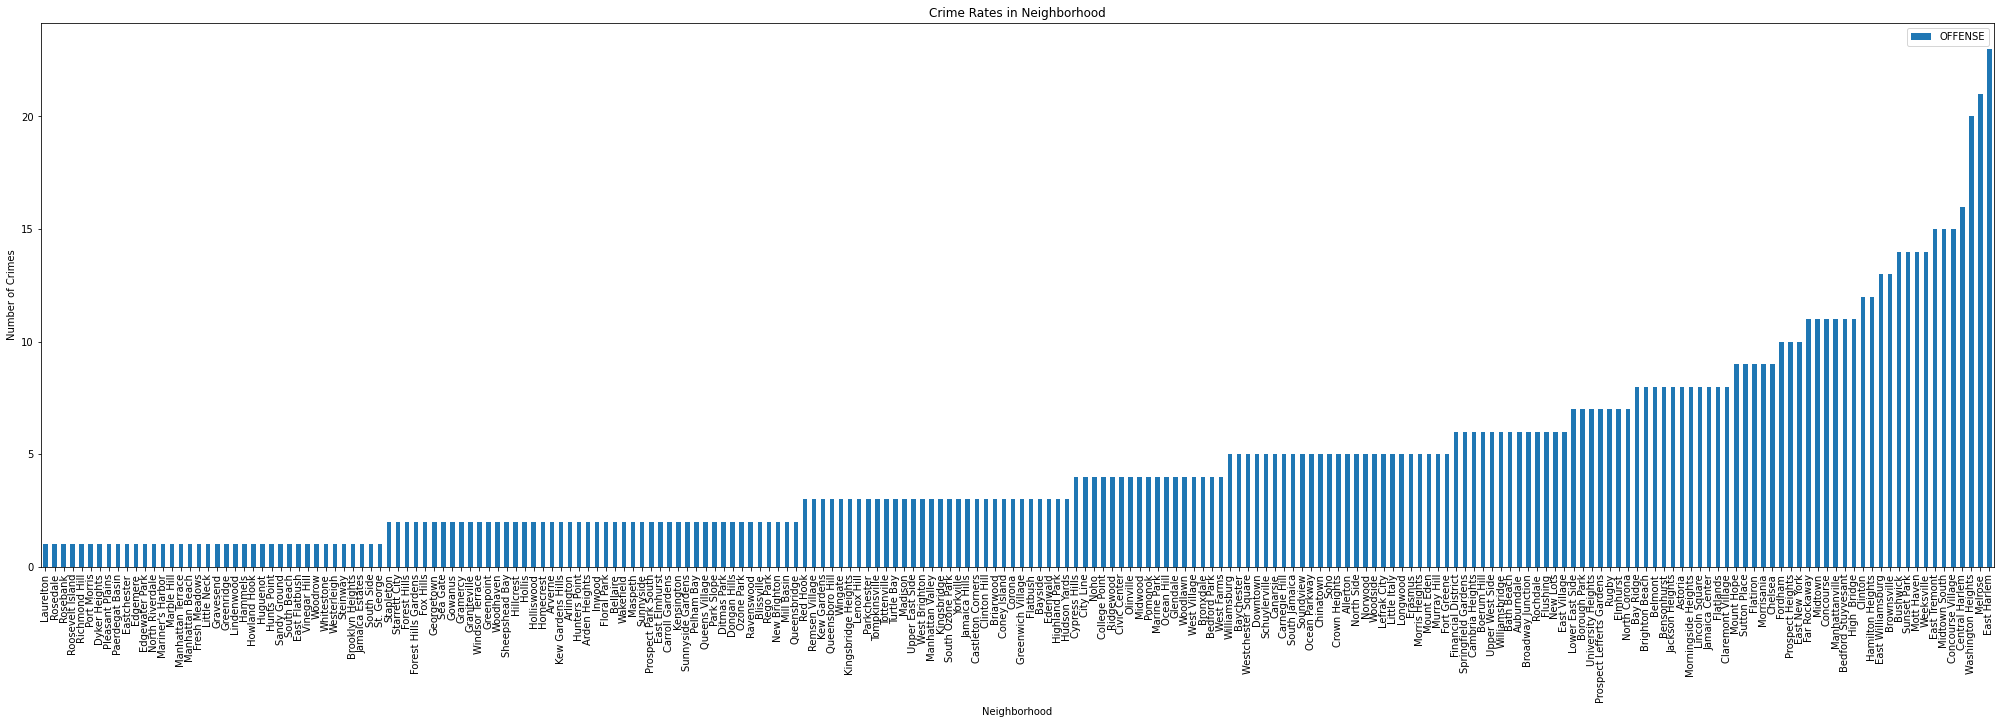

In [25]:
%matplotlib inline
neighcrime_data.plot(kind='bar',stacked=False,figsize=(35,10))
plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.title('Crime Rates in Neighborhood')
plt.show()

In [26]:
neighcrime_data.reset_index(inplace=True)

In [27]:
neighcrime_data.columns

Index(['Neighbourhood', 'OFFENSE'], dtype='object')

In [28]:
#Merging the New York Crime Data with the Neighbourhood Details Table
nycrime_data=pd.merge(nycrime_data,neigh_data[['Neighbourhood','Latitude','Longitude']],on='Neighbourhood',how='left')
nycrime_data=nycrime_data.rename(columns={'Latitude_x':'Crime_Lat','Longitude_x':'Crime_Lon','Latitude_y':'Neigh_Lat','Longitude_y':'Neigh_Lon'})
nycrime_data.head()

DATE                         OFFENSE    BOROUGH  Crime_Lat  Crime_Lon  \
0 2019-04-12  CRIMINAL MISCHIEF & RELATED OF  MANHATTAN  40.764007 -73.996005   
1 2019-04-12                 DANGEROUS DRUGS     QUEENS  40.602195 -73.749104   
2 2019-04-12                   HARRASSMENT 2     QUEENS  40.751482 -73.822033   
3 2019-04-12                   PETIT LARCENY  MANHATTAN  40.718027 -73.999958   
4 2019-04-12                   PETIT LARCENY   BROOKLYN  40.630754 -73.977167   

     Neighbourhood  Neigh_Lat  Neigh_Lon  
0          Clinton  40.759101 -73.996119  
1     Far Rockaway  40.603134 -73.754980  
2  Queensboro Hill  40.744572 -73.825809  
3     Little Italy  40.719324 -73.997305  
4     Borough Park  40.633131 -73.990498

Cholropleth Map of Crime in Neighborhoods

In [41]:
!wget --quiet https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson -O neighborhoods.geojson

In [42]:
neigh_geo=r'neighborhoods.geojson'
neigh_geo

'neighborhoods.geojson'

In [74]:
Neigh_map=folium.Map(location=[40.7128, -74.0060],zoom_start=9,width=900,height=700)
Neigh_map.choropleth(
    geo_data=neigh_geo,
    data=neighcrime_data,
    columns=['Neighbourhood','OFFENSE'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Rates in Neighborhood',
    nan_fill_color='lightyellow',
    nan_fill_opacity=0.7
)
folium.CircleMarker([40.7957, -73.9389],popup='East Harmel: Highest Crime Neighborhood',radius=2,fill_color='red',fill=True).add_to(Neigh_map)
Neigh_map

Finding the desired Neighbourhood having Gym,Grocery Store,Restaurnt,Pharmacy near by.
Using Foursquare to get Venues in a Neighbourhood

In [75]:
#Forusquare id and accesstoken
CLIENT_ID = 'BRIW4D0HG0ZSLYSZOGYS554ZR1OO21CFAN2IRWBCLW4SP2E0' # your Foursquare ID
CLIENT_SECRET = 'W3WWKM4XRSZ5ERFA1HMHH3LC53QRKDCUAFTO5CI5VZPR1MNN' # your Foursquare Secret
ACCESS_TOKEN = 'G1FSY0CD3ZWOHAWIGSJONVHQB35N5V1L4SD0PTR030RTICZW' # your FourSquare Access Token
VERSION = '20210101'
LIMIT = 5
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BRIW4D0HG0ZSLYSZOGYS554ZR1OO21CFAN2IRWBCLW4SP2E0
CLIENT_SECRET:W3WWKM4XRSZ5ERFA1HMHH3LC53QRKDCUAFTO5CI5VZPR1MNN


Defining Function to get near by Venues Using Foursquare API

In [76]:
#Function to get Nearby Venues for each Neighborhoos
def getNearbyVenues(names,latitudes,longitudes,radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [77]:
neigh_data.head()

Borough Neighbourhood   Latitude  Longitude
0   Bronx     Wakefield  40.894705 -73.847201
1   Bronx    Co-op City  40.874294 -73.829939
2   Bronx   Eastchester  40.887556 -73.827806
3   Bronx     Fieldston  40.895437 -73.905643
4   Bronx     Riverdale  40.890834 -73.912585

In [78]:
Ny_venues = getNearbyVenues(names=neigh_data['Neighbourhood'],
                                   latitudes=neigh_data['Latitude'],
                                   longitudes=neigh_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [79]:
Ny_venues['Venue Category'].unique()
Ny_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
4            Subway       40.890468       -73.849152  Sandwich Place

Replacing Different type of Restaurants to just Restaurants

In [80]:
Ny_venues=Ny_venues.replace({'Venue Category':r'^(.*?(\bRestaurant\b)[^$]*)$'},{'Venue Category':'Restaurant'},regex=True)
Ny_venues['Venue Category'].unique()

array(['Dessert Shop', 'Pharmacy', 'Ice Cream Shop', 'Sandwich Place',
       'Pizza Place', 'Discount Store', 'Post Office', 'Bagel Shop',
       'Restaurant', 'Diner', 'Donut Shop', 'Plaza', 'Bus Station',
       'Music Venue', 'Park', 'Bank', 'Baseball Field', 'Gourmet Shop',
       'Yoga Studio', 'Coffee Shop', 'Pub', 'Food Truck', 'Soup Place',
       'Nightclub', 'Bar', 'Metro Station', 'Gym / Fitness Center',
       'Frozen Yogurt Shop', 'Grocery Store', 'Wings Joint',
       'Supermarket', 'Juice Bar', 'Gym', 'Café', 'Mobile Phone Shop',
       'Lounge', 'Market', 'Burger Joint', 'Brewery', 'Distillery',
       'Storage Facility', 'BBQ Joint', 'Fish Market', 'Breakfast Spot',
       'Fried Chicken Joint', 'Pool', 'Sports Bar', 'Playground',
       'Athletics & Sports', 'Deli / Bodega', 'Tennis Stadium', 'Bakery',
       'Food', 'Art Museum', 'Spa', 'Cosmetics Shop', 'Laundry Service',
       'Other Great Outdoors', 'Food & Drink Shop', 'Neighborhood',
       'Jazz Club', 'Conve

In [81]:
#Selecting All the desired Venues from the DF
Ny_venues=Ny_venues.loc[(Ny_venues['Venue Category'].isin(['Gym','Grocery Store','Pharmacy'])|(Ny_venues['Venue Category'].str.contains('Restaurant')))]
#Counting the Number of Venues in each Category
Neigh_venues=Ny_venues.groupby(['Neighborhood','Venue Category'])['Venue Category'].count()
Neigh_venues=Neigh_venues.to_frame()
#Changing index to column Header
Neigh_venues=Neigh_venues.rename(columns={'Venue Category':'Venue Count'})
Neigh_venues=Neigh_venues.reset_index()
Neigh_venues.head()
Neigh_venues.columns

Index(['Neighborhood', 'Venue Category', 'Venue Count'], dtype='object')

In [82]:
Neigh_venues=Neigh_venues.pivot(index='Neighborhood',columns='Venue Category',values='Venue Count').reset_index().fillna(0)

In [83]:
Neigh_venues.columns.name=None

In [84]:
Neigh_venues.head()

Neighborhood  Grocery Store  Gym  Pharmacy  Restaurant
0       Allerton            0.0  0.0       0.0         1.0
1       Annadale            0.0  0.0       0.0         2.0
2  Arden Heights            0.0  0.0       1.0         0.0
3      Arlington            0.0  0.0       0.0         1.0
4       Arrochar            0.0  0.0       0.0         2.0

In [85]:
#Creating an empty Data Frame
col_name=['Neighborhood','Gym','Grocery','Pharmacy','Restaurant','Score']
nw_venue_df=pd.DataFrame(columns=col_name)
nw_venue_df

Empty DataFrame
Columns: [Neighborhood, Gym, Grocery, Pharmacy, Restaurant, Score]
Index: []

In [86]:
#Calculating the score for each neighboor based on the weigheted average
for i,r in Neigh_venues.iterrows():
    s=r['Gym']*2+r['Grocery Store']*3+r['Pharmacy']*2+r['Restaurant']*3
    sco=s/10
    nw_venue_df=nw_venue_df.append({'Neighborhood':r['Neighborhood'],'Gym':r['Gym'],'Grocery':r['Grocery Store'],'Pharmacy':r['Pharmacy'],'Restaurant':r['Restaurant'],'Score':sco},ignore_index=True)

In [87]:
nw_venue_df.head()

Neighborhood  Gym  Grocery  Pharmacy  Restaurant  Score
0       Allerton  0.0      0.0       0.0         1.0    0.3
1       Annadale  0.0      0.0       0.0         2.0    0.6
2  Arden Heights  0.0      0.0       1.0         0.0    0.2
3      Arlington  0.0      0.0       0.0         1.0    0.3
4       Arrochar  0.0      0.0       0.0         2.0    0.6

In [88]:
neighcrime_data.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)
neighcrime_data.head()

Neighborhood  OFFENSE
0         Laurelton        1
1          Rosedale        1
2          Rosebank        1
3  Roosevelt Island        1
4     Richmond Hill        1

In [90]:
#Combining the both crime dataset along with the venues nearby
NY_DF=pd.merge(neighcrime_data,nw_venue_df,on='Neighborhood',how='left')
NY_DF.head()

Neighborhood  OFFENSE  Gym  Grocery  Pharmacy  Restaurant  Score
0         Laurelton        1  0.0      0.0       0.0         2.0    0.6
1          Rosedale        1  0.0      0.0       1.0         1.0    0.5
2          Rosebank        1  0.0      0.0       0.0         3.0    0.9
3  Roosevelt Island        1  0.0      0.0       0.0         1.0    0.3
4     Richmond Hill        1  0.0      0.0       0.0         2.0    0.6

Now we use the KMeans cluster Algorithm to find the best Neighborhood to live in. For this First we have to determine the value of 'K'. I have used the WSS/Elbow Method and Silhouette Method to determine the best value of K.

In [91]:
#Finding Best Value of K using Elbow Method.
Cluster=NY_DF.drop('Neighborhood',1)
Cluster.dropna(inplace=True)
C=[]
for i in range(1,10):
    KM=KMeans(n_clusters=i,max_iter=500)
    KM.fit(Cluster)
    C.append(KM.inertia_)

In [93]:
plt.plot(range(1,10),C,color='g')
plt.xlabel('Different Values of K')
plt.ylabel('WSS')
plt.show()

At k=3 the above plot has an elbow

In [94]:
#Finding the Best Value of K using the silhouette method
sil=[]
kmax=10
for k in range(2,kmax):
    kmeans=KMeans(n_clusters=k).fit(Cluster)
    labels=kmeans.labels_
    sil.append(silhouette_score(Cluster,labels,metric='euclidean'))

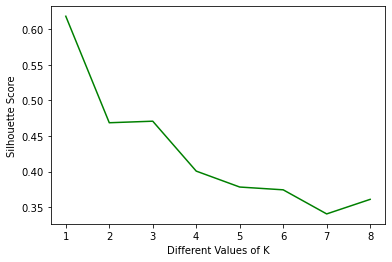

In [95]:
plt.plot(range(1,9),sil,color='g')
plt.xlabel('Different Values of K')
plt.ylabel('Silhouette Score')
plt.show()

At k=3 there is peak in silhouette score

Building the cluster with K=3

In [98]:
#Building cluster with k=3k
clusters=3
cluster_km=KMeans(n_clusters=kclusters,random_state=0).fit(Cluster)
lbl=cluster_km.labels_

In [99]:
#Merging the Cluster Labels with the dataframe
NY_DF.dropna(inplace=True)
NY_DF.insert(0,'Cluster Labels',lbl)
NY_DF.head()

Cluster Labels      Neighborhood  OFFENSE  Gym  Grocery  Pharmacy  \
0               1         Laurelton        1  0.0      0.0       0.0   
1               1          Rosedale        1  0.0      0.0       1.0   
2               1          Rosebank        1  0.0      0.0       0.0   
3               1  Roosevelt Island        1  0.0      0.0       0.0   
4               1     Richmond Hill        1  0.0      0.0       0.0   

   Restaurant  Score  
0         2.0    0.6  
1         1.0    0.5  
2         3.0    0.9  
3         1.0    0.3  
4         2.0    0.6

In [100]:
nycrime_data.head()
nycrime_data.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)

In [101]:
NY_merged=pd.merge(nycrime_data,NY_DF,on='Neighborhood')
NY_merged.head()

DATE                       OFFENSE_x    BOROUGH  Crime_Lat  Crime_Lon  \
0 2019-04-12  CRIMINAL MISCHIEF & RELATED OF  MANHATTAN  40.764007 -73.996005   
1 2019-04-12    ASSAULT 3 & RELATED OFFENSES  MANHATTAN  40.755959 -73.990729   
2 2019-04-12                   PETIT LARCENY  MANHATTAN  40.759794 -73.995854   
3 2019-04-12  CRIMINAL MISCHIEF & RELATED OF  MANHATTAN  40.762299 -73.986107   
4 2019-04-12         MISCELLANEOUS PENAL LAW  MANHATTAN  40.756266 -73.990501   

  Neighborhood  Neigh_Lat  Neigh_Lon  Cluster Labels  OFFENSE_y  Gym  Grocery  \
0      Clinton  40.759101 -73.996119               0         12  0.0      0.0   
1      Clinton  40.759101 -73.996119               0         12  0.0      0.0   
2      Clinton  40.759101 -73.996119               0         12  0.0      0.0   
3      Clinton  40.759101 -73.996119               0         12  0.0      0.0   
4      Clinton  40.759101 -73.996119               0         12  0.0      0.0   

   Pharmacy  Restaurant  Score  
0       0.0         1.0    0.3  
1       0.0         1.0    0.3  
2       0.0         1.0    0.3  
3       0.0         1.0    0.3  
4       0.0         1.0    0.3

In [102]:
#Creating Map
#create a map of Toronoto
cluster_map=folium.Map(location=[40.71, -74.0],zoom_start=11)
#Set color scheme for the clusters
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

#add markers on top
for lat,lng,poi,cluster in zip(NY_merged['Neigh_Lat'],NY_merged['Neigh_Lon'],NY_merged['Neighborhood'],NY_merged['Cluster Labels']):
   # label='{},{}'.format(neighbourhood,borough)
    label=folium.Popup(str(poi)+'Cluster'+str(cluster),parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False
    ).add_to(cluster_map)
cluster_map

In [103]:
NY_DF.loc[NY_DF['Cluster Labels']==0]

Cluster Labels        Neighborhood  OFFENSE  Gym  Grocery  Pharmacy  \
195               0        Far Rockaway       11  0.0      0.0       0.0   
196               0             Midtown       11  0.0      0.0       0.0   
197               0           Concourse       11  0.0      0.0       0.0   
198               0      Manhattanville       11  0.0      0.0       0.0   
199               0  Bedford Stuyvesant       11  0.0      0.0       0.0   
200               0        High  Bridge       11  1.0      0.0       2.0   
201               0             Clinton       12  0.0      0.0       0.0   
202               0    Hamilton Heights       12  0.0      0.0       0.0   
203               0   East Williamsburg       13  0.0      0.0       0.0   
204               0         Brownsville       13  0.0      0.0       0.0   
205               0            Bushwick       14  0.0      0.0       0.0   
206               0         Sunset Park       14  0.0      0.0       0.0   
207               0          Mott Haven       14  1.0      0.0       0.0   
208               0          Weeksville       14  0.0      0.0       0.0   
209               0        East Tremont       15  0.0      0.0       0.0   
210               0       Midtown South       15  0.0      0.0       0.0   
211               0   Concourse Village       15  0.0      0.0       0.0   
212               0      Central Harlem       16  0.0      0.0       0.0   
213               0  Washington Heights       20  0.0      0.0       0.0   
214               0             Melrose       21  1.0      0.0       0.0   
215               0         East Harlem       23  0.0      0.0       0.0   

     Restaurant  Score  
195         2.0    0.6  
196         2.0    0.6  
197         2.0    0.6  
198         1.0    0.3  
199         1.0    0.3  
200         0.0    0.6  
201         1.0    0.3  
202         1.0    0.3  
203         1.0    0.3  
204         1.0    0.3  
205         3.0    0.9  
206         4.0    1.2  
207         1.0    0.5  
208         1.0    0.3  
209         1.0    0.3  
210         1.0    0.3  
211         2.0    0.6  
212         2.0    0.6  
213         2.0    0.6  
214         0.0    0.2  
215         3.0    0.9

In [104]:
NY_DF.loc[NY_DF['Cluster Labels']==1]

Cluster Labels      Neighborhood  OFFENSE  Gym  Grocery  Pharmacy  \
0                 1         Laurelton        1  0.0      0.0       0.0   
1                 1          Rosedale        1  0.0      0.0       1.0   
2                 1          Rosebank        1  0.0      0.0       0.0   
3                 1  Roosevelt Island        1  0.0      0.0       0.0   
4                 1     Richmond Hill        1  0.0      0.0       0.0   
..              ...               ...      ...  ...      ...       ...   
124               1        Ocean Hill        4  0.0      0.0       0.0   
126               1          Woodlawn        4  0.0      0.0       0.0   
127               1      West Village        4  0.0      0.0       0.0   
128               1         Bronxdale        4  0.0      0.0       0.0   
129               1      Bedford Park        4  0.0      0.0       0.0   

     Restaurant  Score  
0           2.0    0.6  
1           1.0    0.5  
2           3.0    0.9  
3           1.0    0.3  
4           2.0    0.6  
..          ...    ...  
124         2.0    0.6  
126         2.0    0.6  
127         3.0    0.9  
128         3.0    0.9  
129         1.0    0.3  

[103 rows x 8 columns]

In [105]:
NY_DF.loc[NY_DF['Cluster Labels']==2]    

Cluster Labels               Neighborhood  OFFENSE  Gym  Grocery  \
131               2               Williamsburg        5  1.0      0.0   
132               2                 Baychester        5  0.0      0.0   
133               2         Westchester Square        5  0.0      0.0   
134               2                   Downtown        5  0.0      1.0   
135               2              Schuylerville        5  0.0      0.0   
136               2                   Canarsie        5  1.0      0.0   
137               2              Carnegie Hill        5  1.0      0.0   
138               2              South Jamaica        5  0.0      1.0   
139               2                  Soundview        5  0.0      1.0   
141               2                  Chinatown        5  0.0      0.0   
144               2                   Allerton        5  0.0      0.0   
145               2                 North Side        5  0.0      0.0   
147               2                   Woodside        5  0.0      0.0   
149               2               Little Italy        5  0.0      0.0   
150               2                   Longwood        5  0.0      1.0   
151               2                    Erasmus        5  0.0      0.0   
152               2             Morris Heights        5  0.0      1.0   
153               2                 Mount Eden        5  1.0      0.0   
154               2                Murray Hill        5  0.0      0.0   
155               2                Fort Greene        5  0.0      0.0   
156               2         Financial District        6  0.0      0.0   
157               2        Springfield Gardens        6  1.0      0.0   
158               2            Cambria Heights        6  0.0      0.0   
159               2                Boerum Hill        6  0.0      0.0   
160               2            Upper West Side        6  0.0      0.0   
161               2             Williamsbridge        6  0.0      0.0   
163               2                 Auburndale        6  0.0      0.0   
164               2          Broadway Junction        6  0.0      0.0   
165               2                   Rochdale        6  0.0      0.0   
166               2                   Flushing        6  1.0      0.0   
167               2                   New Lots        6  0.0      1.0   
168               2               East Village        6  0.0      0.0   
169               2            Lower East Side        7  0.0      0.0   
170               2               Borough Park        7  0.0      0.0   
171               2         University Heights        7  0.0      1.0   
172               2  Prospect Lefferts Gardens        7  0.0      0.0   
173               2                      Rugby        7  0.0      0.0   
174               2                   Elmhurst        7  0.0      0.0   
175               2               North Corona        7  0.0      0.0   
177               2             Brighton Beach        8  0.0      0.0   
178               2                    Belmont        8  0.0      0.0   
179               2                Bensonhurst        8  0.0      0.0   
180               2            Jackson Heights        8  0.0      1.0   
181               2                    Astoria        8  1.0      0.0   
184               2             Jamaica Center        8  1.0      0.0   
185               2                  Flatlands        8  0.0      0.0   
186               2          Claremont Village        8  1.0      1.0   
188               2               Sutton Place        9  1.0      1.0   
189               2                   Flatiron        9  1.0      0.0   
191               2                    Chelsea        9  0.0      0.0   
192               2                    Fordham       10  1.0      0.0   
193               2           Prospect Heights       10  0.0      0.0   
194               2              East New York       10  1.0      0.0   

     Pharmacy  Restaurant  Score  
131       0.0         0.0  

The careful examination of all the 3 clusters indicates that the Cluster 1 has neighborhoods with best amenities score and moderate amount of crime rate.

In [111]:
Best_Cluster=NY_DF.loc[NY_DF['Cluster Labels']==1].sort_values(by='Score',ascending=False)

In [112]:
Best_Cluster

Cluster Labels   Neighborhood  OFFENSE  Gym  Grocery  Pharmacy  \
66                1      Sunnyside        2  1.0      1.0       0.0   
118               1      Ridgewood        4  0.0      0.0       0.0   
102               1  Jamaica Hills        3  0.0      0.0       0.0   
70                1     Kensington        2  0.0      1.0       0.0   
80                1      Rego Park        2  0.0      0.0       0.0   
..              ...            ...      ...  ...      ...       ...   
88                1        Wingate        3  0.0      0.0       1.0   
101               1      Yorkville        3  1.0      0.0       0.0   
121               1        Midwood        4  0.0      0.0       1.0   
43                1     Georgetown        2  0.0      0.0       1.0   
60                1  Arden Heights        2  0.0      0.0       1.0   

     Restaurant  Score  
66          4.0    1.7  
118         4.0    1.2  
102         4.0    1.2  
70          3.0    1.2  
80          4.0    1.2  
..          ...    ...  
88          0.0    0.2  
101         0.0    0.2  
121         0.0    0.2  
43          0.0    0.2  
60          0.0    0.2  

[103 rows x 8 columns]

From the above cluster it is clear that Sunnyside is the best neighborhood to live in with having only 2 offences reported in past one year and having a amenities score of 1.7

In [123]:
# Getting sunnyside Locations.
SunnySide=NY_merged.loc[NY_merged['Neighborhood']=='Sunnyside']
SunnySide
Sunnyside_venues=Ny_venues.loc[Ny_venues['Neighborhood']=='Sunnyside']
Sunnyside_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
696     Sunnyside              40.740176              -73.926916   
698     Sunnyside              40.740176              -73.926916   
699     Sunnyside              40.740176              -73.926916   
1076    Sunnyside              40.612760              -74.097126   
1077    Sunnyside              40.612760              -74.097126   
1079    Sunnyside              40.612760              -74.097126   

                        Venue  Venue Latitude  Venue Longitude Venue Category  
696                Fish House       40.740322       -73.923142     Restaurant  
698              Don Pollo II       40.740049       -73.923763     Restaurant  
699           I Love Paraguay       40.741087       -73.921490     Restaurant  
1076    Mignosi's Supermarket       40.612132       -74.099716  Grocery Store  
1077            The RoadHouse       40.613532       -74.100814     Restaurant  
1079  Spiro Sports Center Gym       40.615470       -74.095453            Gym

In [146]:
Sunnyside_map=folium.Map(location=[40.740176, -74.097126],zoom_start=8,width=800,height=500)
incidents=folium.plugins.MarkerCluster().add_to(Sunnyside_map)
for lat,lng,label in zip(SunnySide.Crime_Lat,SunnySide.Crime_Lon,SunnySide.OFFENSE_x):
    folium.features.CircleMarker(
    [lat,lng],radius=5,color='red',fill=True,fill_color='blue',fill_opacity=0.6,popup=label).add_to(incidents)
for lat,lng,label in zip(Sunnyside_venues['Venue Latitude'],Sunnyside_venues['Venue Longitude'],Sunnyside_venues['Venue']):
    print(label)
    folium.Marker(
    [lat,lng],popup=label).add_to(Sunnyside_map)


Fish House
Don Pollo II
I Love Paraguay
Mignosi's Supermarket
The RoadHouse
Spiro Sports Center Gym


In [147]:
Sunnyside_map